In [1]:
import os, sys
import pandas as pd
import shutil
import subprocess
import numpy as np
import json
import glob

## Inputs

In [2]:
input="scfd_tcr"
input_pdb="/home/tsatler/RFdif/ClusterProteinDesign/scripts/msa_mpnn_af2/input/scfd_tcr/gdscIgV_AF.pdb"
input_a3m=""

fix_positions=np.array([144,147,148,149,151,153,198,201,216,217]) # Positions to fix (numbering should be the same as with input sequence)
conservation=[0.5, 0.7] # Fraction of conserved residues to fix

# prepare out dir
os.makedirs(f"input/{input}", exist_ok=True)
os.makedirs(f"output/{input}", exist_ok=True)

## Functions

In [3]:
sys.path.append('helper_scripts/')
from mmseq_api import run_mmseq2_msa_rosettafold, generate_fasta_sequence_from_pdb, parse_fasta
from parse_msa import get_conserved_positions, process_a3m_file_rf2
from parse_mpnn_seqs import extract_scores, calculate_seq_identity
from plot_scores import create_and_save_plot

## get input sequence

In [6]:
# Parse PDB
seqs = generate_fasta_sequence_from_pdb(input_pdb,f"input/{input}/")
for chain_name, sequence in seqs.items():
    print(f"Chain {chain_name}: {len(sequence)}")
seqs

Chain A: 253


{'A': 'IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMTFIYREKDIYGPGFKDNFQGDIDIAKNLAVLKILAPSERDEGSYYCASDTLGMGGEYTDKLIFGKGTRVTVEGGGGSGGGGSGGGGSGHLEQPQISSTKTLSKTARLECVVSGITISATSVYWYRERPGEVIQFLVSISYDGTVRKESGIPSGKFEVDRIPETSTSTLTIHNVEKQDIATYYCALWEAQQELGKKIKVFGPGTKLIIT'}

In [7]:
# Input sequence
input_sequence = ":".join(seqs.values())
input_sequence

'IELVPEHQTVPVSIGVPATLRCSMKGEAIGNYYINWYRKTQGNTMTFIYREKDIYGPGFKDNFQGDIDIAKNLAVLKILAPSERDEGSYYCASDTLGMGGEYTDKLIFGKGTRVTVEGGGGSGGGGSGGGGSGHLEQPQISSTKTLSKTARLECVVSGITISATSVYWYRERPGEVIQFLVSISYDGTVRKESGIPSGKFEVDRIPETSTSTLTIHNVEKQDIATYYCALWEAQQELGKKIKVFGPGTKLIIT'

## MSA generation

In [8]:
msa_path=f"input/{input}/{input}.a3m"
if input_a3m:
    shutil.copy2(input_a3m,msa_path)
    print(f"MSA as input - {input_a3m} (copeid to {msa_path})")
if input_sequence and not input_a3m:
    print("MSA does not exits... GENERATING NEW ONE!")
    run_mmseq2_msa_rosettafold(input_sequence,f"output/{input}",cov=50, id=90, max_msa=2048,mode="unpaired_paired", msa_name="msa")
else:
    print("Provide either sequence for MSA generation or a3m file!")
    

MSA does not exits... GENERATING NEW ONE!
Starting MSA...
getting unpaired MSA


sh: hhfilter: command not found


FileNotFoundError: [Errno 2] No such file or directory: 'output/scfd_tcr/msa/out_msa_0.a3m'

In [95]:
#debug
#run_mmseq2_msa_rosettafold(input_sequence,f"output/{input}",cov=50, id=90, max_msa=2048, mode="unpaired_paired", msa_name="msa")

## Get conserved residues

In [12]:
conserved_positions_dict = {}
fixed_positions_dict = {}

for conv_frac in conservation:
    conserved_positions = get_conserved_positions(msa_path, frac_conserved=conv_frac, min_count=10)
    conserved_positions_dict[conv_frac] = conserved_positions
    fixed_positions_dict[conv_frac] = np.unique(np.hstack((conserved_positions, fix_positions)))

In [13]:
# Print
for conv_frac in conservation: 
    #positions_dict[conv_frac] = (len(conserved_positions), len(fixed_positions))
    print(f"For conservation {conv_frac:.1%}, conserved residues: {len(conserved_positions_dict[conv_frac])} (with fixed: {len(fixed_positions_dict[conv_frac])})")

# Create a dictionary to save in the JSON file
data = {
    'conserved_positions_dict': {k: v.tolist() for k, v in conserved_positions_dict.items()},
    'fixed_positions_dict': {k: v.tolist() for k, v in fixed_positions_dict.items()},
    'fix_positions': fix_positions.tolist(),
    'input_sequence': input_sequence,
    'msa_path': msa_path
}
with open(f'output/{input}/input_data.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)
print(f"\nsaved data in {f'output/{input}/input_data.json'}\n")

# Chimera
print("select in chimera:")
for conv_frac, positions in fixed_positions_dict.items():
    print(f"{100*conv_frac}% conserved:")
    print(f"select #1/A:{','.join(map(str, positions))}")

For conservation 50.0%, conserved residues: 126 (with fixed: 132)
For conservation 70.0%, conserved residues: 177 (with fixed: 181)

saved data in output/scfd_tcr/input_data.json

select in chimera:
50.0% conserved:
select #1/A:1,2,3,4,5,6,7,11,12,14,15,17,20,21,22,25,26,32,36,37,38,39,41,42,45,46,47,55,58,59,62,63,64,66,68,70,72,73,76,78,79,80,81,84,85,86,87,89,90,91,92,108,109,110,111,112,114,115,116,117,118,119,120,123,124,125,128,129,130,135,137,139,141,143,144,147,148,149,150,151,152,153,154,157,168,169,170,171,172,173,174,177,180,182,185,193,194,195,196,197,198,199,200,201,202,203,204,205,207,213,214,215,216,217,218,219,221,222,224,226,227,228,229,231,244,245,247,248,249,250,252,253
70.0% conserved:
select #1/A:1,2,3,4,5,6,7,8,9,11,12,13,14,15,17,18,20,21,22,23,24,25,26,29,31,32,33,36,37,38,39,41,42,43,44,45,46,47,48,50,55,58,59,60,61,62,63,64,65,66,68,70,72,73,74,75,76,77,78,79,80,81,82,84,85,86,87,88,89,90,91,92,93,108,109,110,111,112,114,115,116,117,118,119,120,121,122,123,124

## Prepare for MPNN

In [134]:
### ProteinMPNN setup
proteinmpnn_dir = '/home/tsatler/ProteinMPNN'
parse_multiple_chains_script = f'{proteinmpnn_dir}/helper_scripts/parse_multiple_chains.py'
assign_fixed_chains_script = f'{proteinmpnn_dir}/helper_scripts/assign_fixed_chains.py'
make_fixed_position_script = f'{proteinmpnn_dir}/helper_scripts/make_fixed_positions_dict.py'
make_tied_position_script = f'{proteinmpnn_dir}/helper_scripts/make_tied_positions_dict.py'


### mpnn parameters
mpnn_temp=[0.1, 0.2, 0.3]
soluble_weights=True
number_of_seq=500

# copy pdb to separate folder
mpnn_pdb=f"input/{input}/mpnn_pdb/"
os.makedirs(mpnn_pdb, exist_ok=True)
shutil.copy2(input_pdb,mpnn_pdb)

# chains to design
chains_to_design=""
chains_to_design=",".join(seqs.keys())
print(f"designing chains: {chains_to_design}")

# use soluble weights
soluble_weights_flag=""
if soluble_weights:
    soluble_weights_flag=" --use_soluble_model"

# temps
temps=" ".join(map(str, mpnn_temp))

designing chains: A


In [136]:
### Prepare MPNN script
mpnn_outdir=f"output/{input}/mpnn_out"
os.makedirs(mpnn_outdir, exist_ok=True)

for conv_frac, positions in fixed_positions_dict.items():
    fixed_positions=' '.join([str(i) for i in positions])
    conv_perc=int(conv_frac*100)
    seq_out=f"{mpnn_outdir}/mpnn_conv{conv_perc}"
    os.makedirs(seq_out, exist_ok=True)

    mpnn_txt = \
f'''#!/bin/bash
#SBATCH -J scFvCD19-mpnn
#SBATCH -p gpu
#SBATCH --gres=gpu:A40:1
#SBATCH --output={mpnn_outdir}/mpnn_conv{conv_perc}.out

source /home/tsatler/anaconda3/etc/profile.d/conda.sh
conda activate mlfold

folder_with_pdbs='{mpnn_pdb}'
path_for_parsed_chains='{seq_out}/parsed_pdbs.jsonl'
path_for_assigned_chains='{seq_out}/assigned_pdbs.jsonl'
path_for_fixed_positions='{seq_out}/fixed_pdbs.jsonl'
path_for_tied_positions='{seq_out}/tied_pdbs.jsonl'
chains_to_design="{chains_to_design}"
path_for_designed_sequences='{seq_out}' 

python {parse_multiple_chains_script} --input_path=$folder_with_pdbs --output_path=$path_for_parsed_chains
python {assign_fixed_chains_script} --input_path=$path_for_parsed_chains --output_path=$path_for_assigned_chains --chain_list "$chains_to_design"
python {make_fixed_position_script} --input_path=$path_for_parsed_chains --position_list "{fixed_positions}" --chain_list "$chains_to_design" --output_path=$path_for_fixed_positions
python {make_tied_position_script} --input_path=$path_for_parsed_chains --output_path=$path_for_tied_positions --homooligomer 1

python {proteinmpnn_dir}/protein_mpnn_run.py \
    --jsonl_path $path_for_parsed_chains \
    --chain_id_jsonl $path_for_assigned_chains \
    --fixed_positions_jsonl $path_for_fixed_positions \
    --tied_positions_jsonl $path_for_tied_positions \
    --out_folder $path_for_designed_sequences \
    --num_seq_per_target {number_of_seq} \
    --sampling_temp "{temps}" \
    --batch_size 8 \
    --omit_AAs='XC' {soluble_weights_flag}
    '''
    script=f"{mpnn_outdir}/run_mpnn_{conv_perc}.sh"

    with open(script,'w') as f:
        f.write(mpnn_txt)
        print(f"Writing mpnn submission script to {script}")


Writing mpnn submission script to output/scfd_tcr/mpnn_out/run_mpnn_50.sh
Writing mpnn submission script to output/scfd_tcr/mpnn_out/run_mpnn_70.sh


In [137]:
### submit
for conv_frac, positions in fixed_positions_dict.items():
    conv_perc=int(conv_frac*100)
    mpnn_outdir=f"output/{input}/mpnn_out"
    script=f"{mpnn_outdir}/run_mpnn_{conv_perc}.sh"
    cmd=f"sbatch {script}"
    subprocess.run(cmd, shell=True)

Submitted batch job 288543
Submitted batch job 288544


In [138]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            288543       amd run_mpnn  tsatler  R       0:01      1 compute-0-3
            288544       amd run_mpnn  tsatler  R       0:01      1 compute-0-3


## Parse MPNN sequences

In [4]:
# Define the path to the JSON file
json_file_path = f'output/{input}/input_data.json'
with open(json_file_path, 'r') as json_file:
    loaded_data = json.load(json_file)

# Assign the loaded data to the variables
conserved_positions_dict = loaded_data['conserved_positions_dict']
fixed_positions_dict = loaded_data['fixed_positions_dict']
fix_positions = np.array(loaded_data['fix_positions'])
input_sequence = loaded_data['input_sequence']
msa_path = loaded_data['msa_path']

# Print to confirm
print("Loaded data from:", json_file_path)
print("conserved_positions_dict:", conserved_positions_dict)
print("fixed_positions_dict:", fixed_positions_dict)
print("fix_positions:", fix_positions)
print("input_sequence:", input_sequence)
print("msa_path:", msa_path)


Loaded data from: output/scfd_tcr/input_data.json
conserved_positions_dict: {'0.5': [222, 154, 89, 226, 228, 91, 22, 168, 85, 36, 247, 213, 245, 248, 109, 90, 173, 111, 15, 68, 200, 174, 39, 87, 171, 76, 112, 224, 41, 199, 227, 62, 1, 42, 215, 203, 25, 194, 116, 157, 169, 26, 231, 207, 70, 84, 147, 249, 2, 63, 221, 250, 72, 141, 66, 180, 115, 139, 229, 177, 137, 118, 14, 244, 170, 201, 205, 196, 152, 3, 202, 218, 92, 253, 185, 182, 193, 20, 32, 81, 12, 252, 172, 197, 150, 119, 38, 78, 114, 214, 120, 46, 135, 216, 129, 195, 55, 21, 108, 5, 47, 219, 125, 117, 6, 58, 37, 45, 143, 110, 7, 204, 11, 4, 124, 128, 86, 79, 151, 17, 73, 123, 59, 80, 64, 130], '0.7': [222, 154, 89, 226, 228, 91, 22, 168, 85, 36, 247, 213, 245, 248, 109, 90, 173, 111, 15, 68, 200, 174, 39, 87, 171, 76, 112, 224, 41, 199, 227, 62, 1, 42, 215, 203, 25, 194, 116, 157, 169, 26, 231, 207, 70, 84, 147, 249, 2, 63, 221, 250, 72, 141, 66, 180, 115, 139, 229, 177, 137, 118, 14, 244, 170, 201, 205, 196, 152, 3, 202, 218, 92

In [5]:
### Parse mpnn sequences
mpnn_outdir=f"output/{input}/mpnn_out"
for conv_frac, positions in fixed_positions_dict.items():
    conv_perc=int(float(conv_frac)*100)
    seqs=glob.glob(f"{mpnn_outdir}/mpnn_conv{conv_perc}/seqs/*.fa")[0]
    df=extract_scores(seqs)
    df = df.drop_duplicates("seq")
    df["original_seq"]=input_sequence
    
    # Sequence identity to input_seq without fixed residues
    df["seq_ident_nofixed"]=df.apply(lambda row: calculate_seq_identity(row['original_seq'], row['seq'],positions), axis=1)
    
    # Sequence identity to input_seq
    df["seq_ident"]=df.apply(lambda row: calculate_seq_identity(row['original_seq'], row['seq'],[]), axis=1)
    
    # Add unique ID
    df["id"]=None
    df = df[['id'] + [col for col in df if col != 'id']]

    for i,row in df.iterrows():
        sample_id = row["sample"]
        temp = row["temp"]
        df.at[i, 'id'] = f"{input}_conv{conv_perc}_{sample_id}_{str(temp).replace('.', '')}"

    
    df_save=f"output/{input}/mpnn_out/mpnn_seqs_conv{conv_perc}.csv"
    df.to_csv(df_save, index=False)

    print(f"Dataframe with {conv_perc}% fixed conserved residues and {df.shape[0]} sequences!")
    print(f"Dataframe saved to: {df_save}")



Dataframe with 50% fixed conserved residues and 1488 sequences!
Dataframe saved to: output/scfd_tcr/mpnn_seqs_conv50.csv
Dataframe with 70% fixed conserved residues and 1488 sequences!
Dataframe saved to: output/scfd_tcr/mpnn_seqs_conv70.csv


## Run AF2 predictions

In [62]:
### Colabfold arguments
array_limit=5
colabfold_args="--num-recycle 12"

### prepare MSAs based on initial msa
af2_folder=f"output/{input}/af2"
af2_best_folder=f"output/{input}/af2/best"
os.makedirs(af2_best_folder, exist_ok=True)

### Prepare AF2 inputs
for conv_frac, positions in fixed_positions_dict.items():
    conv_perc=int(float(conv_frac)*100)
    df = pd.read_csv(f"output/{input}/mpnn_seqs_conv{conv_perc}.csv")
    af2_input_folder=f"{af2_folder}/af2_msa_input_conv{conv_perc}"
    af2_output_folder=f"{af2_folder}/af2_conv{conv_perc}"

    num_a3m = len(df)
    # Create subdirectories if there are more than 1000 files
    num_subdirs = (num_a3m - 1) // 1000 + 1
    for i in range(num_subdirs):
        subdir = f"{af2_input_folder}_{i + 1}"
        os.makedirs(subdir, exist_ok=True)

    for i, row in df.iterrows():
        id = row["id"]
        seq = row["seq"]
        subdir = f"{af2_input_folder}_{i // 1000 + 1}"
        new_a3m_file = f"{subdir}/{id}.a3m"
        process_a3m_file_rf2(seq, msa_path, new_a3m_file)
    
    for i in range(num_subdirs):
        subdir = f"{af2_input_folder}_{i + 1}"
        subout = f"{af2_output_folder}/{i + 1}"
        best_sub=f"{af2_output_folder}/best_{i + 1}"
        os.makedirs(subout, exist_ok=True)
        os.makedirs(best_sub, exist_ok=True)
        a3ms = len(glob.glob(f"{subdir}/*.a3m"))

        # prepare script
        af2_txt = f'''#!/bin/bash
#SBATCH --output=/dev/null
#SBATCH --partition=gpu
#SBATCH --gres=gpu:A40:1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --array=0-{a3ms-1}%{array_limit}

# Activate the AlphaFold2 environment
. /home/aljubetic/bin/set_up_AF2.3.sh

msa_folder={subdir}
input_files=($msa_folder/*.a3m)
file=${{input_files[$SLURM_ARRAY_TASK_ID]}}
basename=$(basename "$file" .a3m)

outdir={subout}
out_subdir="$outdir/$SLURM_ARRAY_TASK_ID"
best_dir={best_sub}
additional_args="{colabfold_args}"

final_pdb=$best_dir/$basename.pdb
final_json=$best_dir/$basename.json

if [ ! -f "$final_pdb" ]; then
    # Run AF2
    cmd="/home/aljubetic/AF2/CF2.3/colabfold-conda/bin/python /home/aljubetic/AF2/CF2.3/colabfold-conda/bin/colabfold_batch $additional_args $file $out_subdir"
    echo $cmd
    $cmd

    # Copy best
    cp $out_subdir/$basename*rank_001*.pdb $final_pdb
    cp $out_subdir/$basename*rank_001*.json $final_json

    # Remove other colabfold files
    rm -r $out_subdir
fi

# Analyze
python helper_scripts/analyze_pdbs.py \
{input_pdb} $final_pdb $final_json {af2_folder} --out_name af2_conv{conv_perc}
'''
        script=f"{af2_folder}/run_af2_conv{conv_perc}_{i}.sh"

        with open(script,'w') as f:
            f.write(af2_txt)
            print(f"Writing ad2 submission script to {script}")

        print(f"{a3ms} a3m sequences with conv{conv_perc}% in {subdir} ready to be predicted!")

    


Writing ad2 submission script to output/scfd_tcr/af2/run_af2_conv50_0.sh
1000 a3m sequences with conv50% in output/scfd_tcr/af2/af2_msa_input_conv50_1 ready to be predicted!
Writing ad2 submission script to output/scfd_tcr/af2/run_af2_conv50_1.sh
488 a3m sequences with conv50% in output/scfd_tcr/af2/af2_msa_input_conv50_2 ready to be predicted!
Writing ad2 submission script to output/scfd_tcr/af2/run_af2_conv70_0.sh
1000 a3m sequences with conv70% in output/scfd_tcr/af2/af2_msa_input_conv70_1 ready to be predicted!
Writing ad2 submission script to output/scfd_tcr/af2/run_af2_conv70_1.sh
488 a3m sequences with conv70% in output/scfd_tcr/af2/af2_msa_input_conv70_2 ready to be predicted!


In [63]:
### Run code
for conv_frac, positions in fixed_positions_dict.items():
    conv_perc=int(float(conv_frac)*100)
    df = pd.read_csv(f"output/{input}/mpnn_seqs_conv{conv_perc}.csv")
    num_a3m = len(df)
    num_subdirs = (num_a3m - 1) // 1000 + 1
    for i in range(num_subdirs):
        script=f"{af2_folder}/run_af2_conv{conv_perc}_{i}.sh"
        cmd=f"sbatch {script}"
        subprocess.run(cmd, shell=True)

Submitted batch job 289387
Submitted batch job 289388
Submitted batch job 289389
Submitted batch job 289390


In [65]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
 289387_[15-999%5]       gpu run_af2_  tsatler PD       0:00      1 (JobArrayTaskLimit)
 289388_[15-487%5]       gpu run_af2_  tsatler PD       0:00      1 (JobArrayTaskLimit)
 289389_[15-999%5]       gpu run_af2_  tsatler PD       0:00      1 (JobArrayTaskLimit)
 289390_[15-487%5]       gpu run_af2_  tsatler PD       0:00      1 (JobArrayTaskLimit)
         289387_11       gpu run_af2_  tsatler  R       1:46      1 compute-0-12
         289387_12       gpu run_af2_  tsatler  R       1:46      1 compute-0-12
         289387_13       gpu run_af2_  tsatler  R       1:46      1 compute-0-12
         289387_14       gpu run_af2_  tsatler  R       1:46      1 compute-0-12
         289387_10       gpu run_af2_  tsatler  R       1:49      1 compute-0-10
         289388_10       gpu run_af2_  tsatler  R       1:54      1 compute-6-3
         289388_11       gpu run_af2_  tsatler  R       1:54      1 compute-6-

## Filter scores and analyze data

In [6]:
# Define the path to the JSON file
json_file_path = f'output/{input}/input_data.json'
with open(json_file_path, 'r') as json_file:
    loaded_data = json.load(json_file)

# Assign the loaded data to the variables
conserved_positions_dict = loaded_data['conserved_positions_dict']
fixed_positions_dict = loaded_data['fixed_positions_dict']
fix_positions = np.array(loaded_data['fix_positions'])
input_sequence = loaded_data['input_sequence']
msa_path = loaded_data['msa_path']


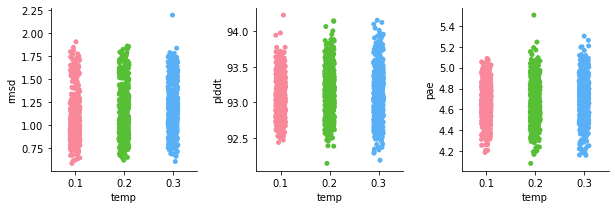

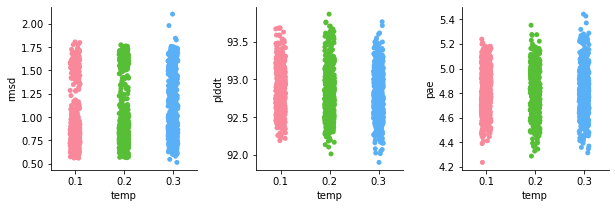

In [7]:
for conv_frac, positions in fixed_positions_dict.items():
    conv_perc=int(float(conv_frac)*100)
    mpnn_path=f"output/{input}/mpnn_out/mpnn_seqs_conv{conv_perc}.csv"
    af2_path=f"output/{input}/af2/af2_conv{conv_perc}.csv"

    # Open dataframes
    mpnn_scores=pd.read_csv(mpnn_path)
    af2_scores=pd.read_csv(af2_path)
    af2_scores["id"]=af2_scores["model_id"]

    # Merge and save dataframes
    merged_df = pd.merge(af2_scores, mpnn_scores, on='id', how='inner')
    merged_df = merged_df.sort_values("plddt", ascending=False)
    merged_df.to_csv(f"output/{input}/af2_mpnn_{input}_conv{conv_perc}.csv")

    # Plot scores
    create_and_save_plot(merged_df, f"output/{input}/scores_{input}_conv{conv_perc}.png")